In [3]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install tqdm
!pip install yfinance
!pip install wordcloud
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import plotly.express as px4
from dash import dcc, html
from datetime import timedelta
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

**구글 드라이브 연결**

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


**데이터 불러오기**

In [10]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/StockGeine/datasets/한화오션_aggregated.csv')
stock_df = pd.read_csv('/content/drive/MyDrive/StockGeine/stock/한화오션_stock_dataset.csv')

sentiment_df['publish_date'] = pd.to_datetime(sentiment_df['publish_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True).dt.date
sentiment_df['publish_date'] = sentiment_df['publish_date'].dt.date

sentiment_df.rename(columns={'publish_date': 'Date'}, inplace=True)
data = pd.merge(stock_df, sentiment_df, on='Date', how='inner')
data['Date'] = pd.to_datetime(data['Date']).dt.date

print()
print()
print("Merged DataFrame Head")
print(data.head())



Merged DataFrame Head
         Date     Open     High      Low    Close    Volume  Dividends  \
0  2024-10-30  27350.0  27450.0  26350.0  26750.0   1302949        0.0   
1  2024-11-10  37550.0  39350.0  36650.0  37300.0  12098563        0.0   
2  2024-11-11  37550.0  39200.0  36000.0  36800.0  11247222        0.0   
3  2024-11-12  37900.0  37900.0  33650.0  33800.0  12598160        0.0   
4  2024-11-13  33950.0  39450.0  33900.0  39200.0  19865082        0.0   

   Stock Splits  positive   neutral  negative     total  
0           0.0  0.200643  0.000295  0.799062  negative  
1           0.0  0.422296  0.159910  0.417795  positive  
2           0.0  0.175524  0.002197  0.822280  negative  
3           0.0  0.094318  0.037512  0.868170  negative  
4           0.0  0.066369  0.064252  0.869380  negative  


### 데이터 전처리
불필요한 데이터 제거

In [11]:
data.drop(['Dividends', 'Stock Splits', 'total'], axis=1, inplace=True)

print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
positive    0
neutral     0
negative    0
dtype: int64


**결측값 확인 및 처리**

### 특징 생성, 데이터 분할
**positive, neutral, negative 점수를 활용하여 종합적인 감성 점수를 생성**

In [12]:
data['sentiment_score'] = data['positive'] - data['negative']

## 중립점수를 가중치로 사용 - 국내만 적용
data['sentiment_score'] = data['sentiment_score'] * (1 - data['neutral'])


**다음 날의 종가를 예측 대상으로 설정**

In [13]:
# 다음 날 종가 생성
data['Next_Close'] = data['Close'].shift(-1)

data = data[:-1]
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score']
X = data[features]


y = data['Next_Close']

# 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### 모델 학습
**XGBoost 모델 생성 및 학습**

objective를 회귀 문제에 맞게 'reg:squarederror'로 설정합니다.
eval_metric으로 RMSE를 사용

In [14]:
# XGBoost 회귀 모델 생성
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("Best parameters found: ", grid_search.best_params_)


# DMatrix 생성 (XGBoost 전용 데이터 구조)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 하이퍼파라미터 설정
params = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'reg:squarederror',  # 회귀 문제이므로 reg:squarederror 사용
    'eval_metric': 'rmse'
}

# 모델 학습
num_rounds = best_params['n_estimators']  # 최적의 n_estimators 설정
model = xgb.train(params, dtrain, num_rounds)


# 테스트 세트 예측
y_pred = model.predict(dtest)


Best parameters found:  {'eta': 0.01, 'max_depth': 3, 'n_estimators': 100}


**모델 성능 테스트**

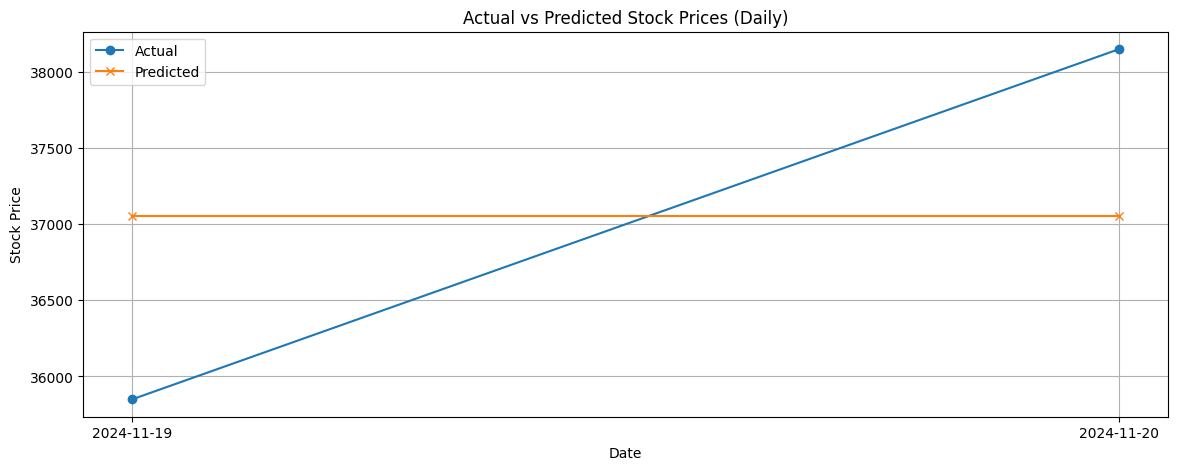

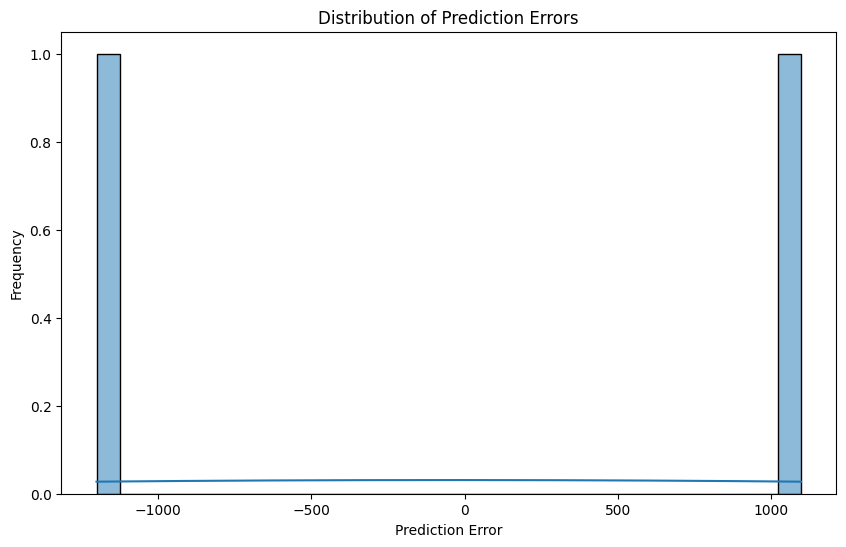

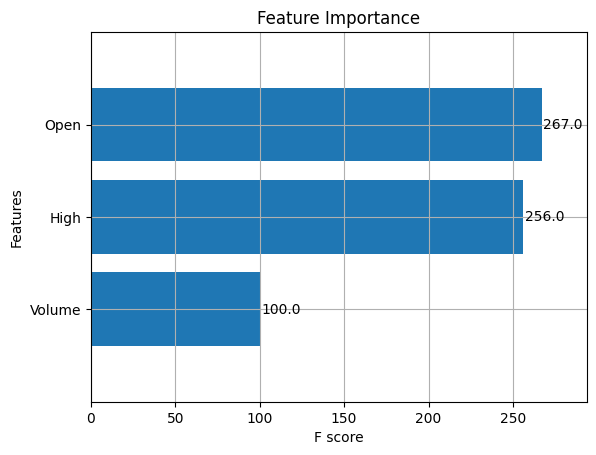

RMSE: 1151.17
MAE: 1150.00
R² Score: -0.00


주가 방향성 예측 정확도: 0.00%

혼동 행렬:
[[0 1]
 [1 0]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

         Date  Previous_Close  Actual_Next_Close  Predicted_Next_Close  \
0  2024-11-19         37050.0            35850.0           37051.84375   
1  2024-11-20         37550.0            38150.0           37051.84375   

   Actual_Movement  Predicted_Movement  
0                0                   1  
1                1                   0  


In [16]:
dates = data['Date'].iloc[y_train.shape[0]:].reset_index(drop=True) # 날짜만 가져옴

# 결과 데이터프레임 생성
results = pd.DataFrame({'Date': dates, 'Actual': y_test.reset_index(drop=True), 'Predicted': y_pred})

# 'Date' 열을 datetime 형식으로 변환
results['Date'] = pd.to_datetime(results['Date'])
results.set_index('Date', inplace=True)


######################## 날짜 기준 그래프 시각화
plt.figure(figsize=(14, 5))
plt.plot(results['Actual'], label='Actual', marker='o')
plt.plot(results['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Stock Prices (Daily)')
plt.xlabel('Date')
plt.ylabel('Stock Price')


plt.xticks(results.index)  # 결과 데이터프레임의 인덱스를 x축 틱으로 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 지정

plt.legend()
plt.grid()
plt.show()
######################## 히스토그램으로 오차 분포 시각화
errors = y_test.values - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.show()
######################## 특징 중요도 가져오기
xgb.plot_importance(model, height=0.8)
plt.title('Feature Importance')

plt.show()

######################## 성능 평가
# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# R² 스코어 계산
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print()

# 테스트 데이터에서 이전 날의 종가 가져오기
# 수정: y_test와 길이를 맞추기 위해 동일한 시작 인덱스를 사용
previous_close = data['Close'].iloc[-y_test.shape[0]-1:-1].reset_index(drop=True)

# 실제 방향성 계산 (다음 날 종가 - 이전 날 종가)
actual_direction = y_test.reset_index(drop=True) - previous_close

# 예측된 방향성 계산 (예측된 다음 날 종가 - 이전 날 종가)
predicted_direction = y_pred - previous_close

# 실제 방향성 이진화
actual_movement = np.where(actual_direction > 0, 1, 0)

# 예측된 방향성 이진화
predicted_movement = np.where(predicted_direction > 0, 1, 0)

# 정확도 계산
accuracy = accuracy_score(actual_movement, predicted_movement)

print(f"\n주가 방향성 예측 정확도: {accuracy * 100:.2f}%")

# 혼동 행렬
conf_matrix = confusion_matrix(actual_movement, predicted_movement)
print("\n혼동 행렬:")
print(conf_matrix)

# 분류 보고서
class_report = classification_report(actual_movement, predicted_movement)
print("\n분류 보고서:")
print(class_report)

# 결과 데이터프레임 생성
res = pd.DataFrame({
    'Date': dates,
    'Previous_Close': previous_close,
    'Actual_Next_Close': y_test.reset_index(drop=True),
    'Predicted_Next_Close': y_pred,
    'Actual_Movement': actual_movement,
    'Predicted_Movement': predicted_movement
})

print(res)

In [17]:
# 한국어
model.save_model('kor_pr_model.json')

# 영어
# model.save_model('en_pr_model.json')